In [124]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns

## Column Overlook
- To our current knowledge, the application use case is the following:
    - The user inputs the date range and we output the number of booked rooms for each of the days in that range
    - We can use the evennts table and weather forecast for the test days
- Based on the information we have, it is safe to say that the inputs to our model would be:
    1. Day of the week (1 being monday - 7 being sunday)
    2. Day of the year (1 - 365) - Lets hypotethize for now that the reservations are periodical throughout the years
    3. Room type
    4. Events table
    5. Forecast table
- The target of our model of course, is the number of booked rooms for our inputs

In [125]:
dataset = pd.read_parquet("../lumen_dataset/train.parquet")
dataset.head()

,reservation_id,night_number,stay_date,guest_id,guest_country_id,reservation_status,reservation_date,date_from,date_to,resort_id,...,price,price_tax,total_price_tax,total_price,food_price,food_price_tax,other_price,other_price_tax,room_category_id,sales_channel_id
0,73710,1.0,2007-12-13,22897,HR,Checked-out,2007-11-28,2007-12-13,2007-12-15,1,...,4255.462,425.517,452.089,4564.690,265.428,26.572,43.800,0.000,3,10.0
1,73710,2.0,2007-12-14,22897,HR,Checked-out,2007-11-28,2007-12-13,2007-12-15,1,...,4243.709,424.349,450.921,4552.937,265.428,26.572,43.800,0.000,3,10.0
2,74464,1.0,2008-01-01,106278,HR,Checked-out,2007-12-29,2008-01-01,2008-01-02,1,...,4336.857,433.693,3806.147,19764.823,530.929,53.071,14897.037,3319.383,4,4.0
3,74461,1.0,2008-01-01,38936,GB,Cancelled,2007-12-29,2008-01-01,2008-01-02,1,...,8536.766,853.662,1012.948,10392.280,1592.714,159.286,262.800,0.000,5,3.0
4,74466,1.0,2008-01-01,106279,HR,Cancelled,2007-12-29,2008-01-01,2008-01-03,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,4.0


- Lets also check the data types of our columns

In [126]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31634 entries, 0 to 31633
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   reservation_id      31634 non-null  int64         
 1   night_number        31634 non-null  float64       
 2   stay_date           31634 non-null  datetime64[ns]
 3   guest_id            31634 non-null  int64         
 4   guest_country_id    31634 non-null  object        
 5   reservation_status  31634 non-null  object        
 6   reservation_date    31634 non-null  object        
 7   date_from           31634 non-null  object        
 8   date_to             31634 non-null  object        
 9   resort_id           31634 non-null  int64         
 10  cancel_date         6151 non-null   object        
 11  room_cnt            31634 non-null  int64         
 12  adult_cnt           31634 non-null  int64         
 13  children_cnt        31634 non-null  int64     

### Cancelled Reservations
Based on the specification of our problem, we belive it is safe to say that the cancelled reservations do not impact the final result of our prediction. Therefore we remove those rows for simplicity

In [127]:
dataset = dataset[dataset["cancel_date"].isna()]
dataset.head()

,reservation_id,night_number,stay_date,guest_id,guest_country_id,reservation_status,reservation_date,date_from,date_to,resort_id,...,price,price_tax,total_price_tax,total_price,food_price,food_price_tax,other_price,other_price_tax,room_category_id,sales_channel_id
0,73710,1.0,2007-12-13,22897,HR,Checked-out,2007-11-28,2007-12-13,2007-12-15,1,...,4255.462,425.517,452.089,4564.690,265.428,26.572,43.800,0.000,3,10.0
1,73710,2.0,2007-12-14,22897,HR,Checked-out,2007-11-28,2007-12-13,2007-12-15,1,...,4243.709,424.349,450.921,4552.937,265.428,26.572,43.800,0.000,3,10.0
2,74464,1.0,2008-01-01,106278,HR,Checked-out,2007-12-29,2008-01-01,2008-01-02,1,...,4336.857,433.693,3806.147,19764.823,530.929,53.071,14897.037,3319.383,4,4.0
6,74470,1.0,2008-01-01,38936,GB,Checked-out,2007-12-29,2008-01-01,2008-01-02,1,...,8536.766,853.662,1012.948,10392.280,1592.714,159.286,262.800,0.000,4,3.0
7,74460,1.0,2008-01-01,38936,GB,Checked-out,2007-12-29,2008-01-01,2008-01-02,1,...,8536.766,853.662,1012.948,10392.280,1592.714,159.286,262.800,0.000,5,3.0


### None Values

After dropping the cancelled rows, lets check if there are any none values for our main columns.

In [128]:
none_values_count = dataset["night_number"].isna().sum()

print(f"Number of None/NaN values in 'night_number': {none_values_count}")

Number of None/NaN values in 'night_number': 0


In [129]:
none_values_count = dataset["room_category_id"].isna().sum()

print(f"Number of None/NaN values in 'room_category_id': {none_values_count}")

Number of None/NaN values in 'room_category_id': 0


In [130]:
none_values_count = dataset["room_cnt"].isna().sum()

print(f"Number of None/NaN values in 'room_cnt': {none_values_count}")

Number of None/NaN values in 'room_cnt': 0


In [131]:
none_values_count = dataset["date_from"].isna().sum()

print(f"Number of None/NaN values in 'date_from': {none_values_count}")

Number of None/NaN values in 'date_from': 0


In [132]:
none_values_count = dataset["stay_date"].isna().sum()

print(f"Number of None/NaN values in 'stay_date': {none_values_count}")

Number of None/NaN values in 'stay_date': 0


Removing the two stays in 2007

In [133]:
dataset = dataset[dataset["stay_date"].dt.year != 2007]
dataset.head()

,reservation_id,night_number,stay_date,guest_id,guest_country_id,reservation_status,reservation_date,date_from,date_to,resort_id,...,price,price_tax,total_price_tax,total_price,food_price,food_price_tax,other_price,other_price_tax,room_category_id,sales_channel_id
2,74464,1.0,2008-01-01,106278,HR,Checked-out,2007-12-29,2008-01-01,2008-01-02,1,...,4336.857,433.693,3806.147,19764.823,530.929,53.071,14897.037,3319.383,4,4.0
6,74470,1.0,2008-01-01,38936,GB,Checked-out,2007-12-29,2008-01-01,2008-01-02,1,...,8536.766,853.662,1012.948,10392.280,1592.714,159.286,262.800,0.000,4,3.0
7,74460,1.0,2008-01-01,38936,GB,Checked-out,2007-12-29,2008-01-01,2008-01-02,1,...,8536.766,853.662,1012.948,10392.280,1592.714,159.286,262.800,0.000,5,3.0
8,74493,1.0,2008-01-01,106460,HR,Checked-out,2008-01-01,2008-01-01,2008-01-02,1,...,3996.239,399.602,650.138,5512.303,530.929,53.071,985.135,197.465,4,4.0
9,74495,1.0,2008-01-01,106471,AUT,Checked-out,2008-01-01,2008-01-01,2008-01-02,1,...,4336.857,433.693,3008.622,16398.428,530.929,53.071,11530.642,2521.858,7,3.0


### Room Count
This column represents the number of rooms booked. Lets see how many rooms have people booked in general 

In [134]:
unique_values = dataset["room_cnt"].unique()
print(f"Unique values in 'room_cnt': {unique_values}")

Unique values in 'room_cnt': [ 1  7  3  2  4  6  8  9 29 15  5 12 16 25 14 23 13 31 11 21 10 20 19 28
 30 18 24 34 22 37 27 17 26 50 38 40 33 32]


This could mean it's not enough to just count the stay dates, but maybe we need to include the number of rooms booked as well

In [135]:
value_counts = dataset["room_cnt"].value_counts()

print("Counts of unique values in 'room_cnt':")
print(value_counts)

Counts of unique values in 'room_cnt':
room_cnt
1     20560
2      2814
3       795
4       316
5       127
6        93
8        65
7        57
13       54
9        51
12       42
10       38
11       38
18       36
14       36
21       35
19       31
23       30
22       28
17       27
25       26
15       26
16       21
20       21
24       20
29       17
31       15
27       15
26       11
28        9
30        8
50        5
38        5
33        4
37        2
34        1
40        1
32        1
Name: count, dtype: int64


It seems we were right, people do not book only one room, in fact they book sometimes 50 rooms on one reservation. Now here a question arises if we should treat a single booking of 40 rooms as an anomaly? Or not?

### Room types

In [136]:
unique_room_category_ids = dataset["room_category_id"].unique()

print(f"Unique room category IDs: {unique_room_category_ids}")

Unique room category IDs: [ 4  5  7  2  6  3 11  1]


## Timeframe Analysis
It is crucial to understand how our dataset behaves throughout the dates. First we check the date range we have available data

In [137]:
min_date = dataset["stay_date"].min()
max_date = dataset["stay_date"].max()

print(f"Minimum stay date: {min_date}")
print(f"Maximum stay date: {max_date}")

Minimum stay date: 2008-01-01 00:00:00
Maximum stay date: 2009-12-31 00:00:00


We notice that 2008 and 2009 are the years where we have all of the data. Therefore we do our analysis in context of those years.

First we check the periodicty of these two years by overlooking the number of booked rooms by year. By looking at our dataset, we can see that the column that is telling us about ocupancy for a date is in fact the stay_date column. But we shouldn't forget about the room count column where it tells us how many rooms has the person booked for a stay date 

In [138]:
total_room_nights_2008 = dataset[dataset["stay_date"].dt.year == 2008]["room_cnt"].sum()
total_room_nights_2009 = dataset[dataset["stay_date"].dt.year == 2009]["room_cnt"].sum()

print(f"Total number of room nights booked in 2008: {total_room_nights_2008}")
print(f"Total number of room nights booked in 2009: {total_room_nights_2009}")

Total number of room nights booked in 2008: 22186
Total number of room nights booked in 2009: 21636


Our years seem pretty similar overall. Lets see how our months compare

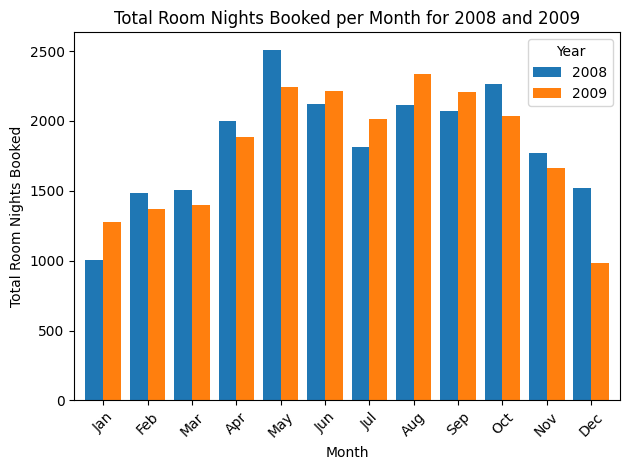

In [139]:
dataset["year"] = dataset["stay_date"].dt.year
dataset["month"] = dataset["stay_date"].dt.month

dataset["total_room_nights"] = dataset["room_cnt"]

grouped_data = (
    dataset.loc[
        (dataset["year"].isin([2008, 2009])), ["year", "month", "total_room_nights"]
    ]
    .groupby(["year", "month"])
    .sum()
)

grouped_unstacked = grouped_data["total_room_nights"].unstack(level=0)

grouped_unstacked.plot(kind="bar", width=0.8)
plt.title("Total Room Nights Booked per Month for 2008 and 2009")
plt.xlabel("Month")
plt.ylabel("Total Room Nights Booked")
plt.xticks(
    ticks=range(12),
    labels=[
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ],
    rotation=45,
)
plt.legend(title="Year", labels=["2008", "2009"])
plt.tight_layout()
plt.show()

The months are almost identical, this is great. We see the rise in number of bookings at spring and summer and a smaller number for the rest of the year. Lets see how this translates to the full dataset

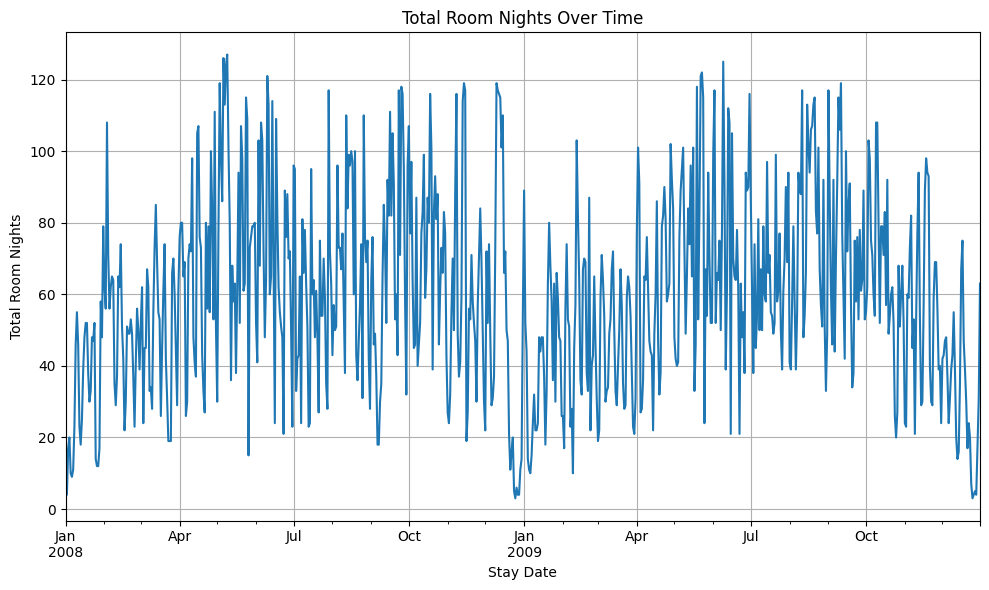

In [140]:
total_room_nights_by_date = dataset.groupby("stay_date")["room_cnt"].sum()

plt.figure(figsize=(10, 6))
total_room_nights_by_date.plot(kind="line")
plt.title("Total Room Nights Over Time")
plt.xlabel("Stay Date")
plt.ylabel("Total Room Nights")
plt.grid(True)
plt.tight_layout()
plt.show()

We clearly see two periods of a signal, them being our two years. It is almost safe to say that our data is periodic. But lets be *extra fancy* and to a Fourier analysis of these signals just to be certain (and for fun) :)

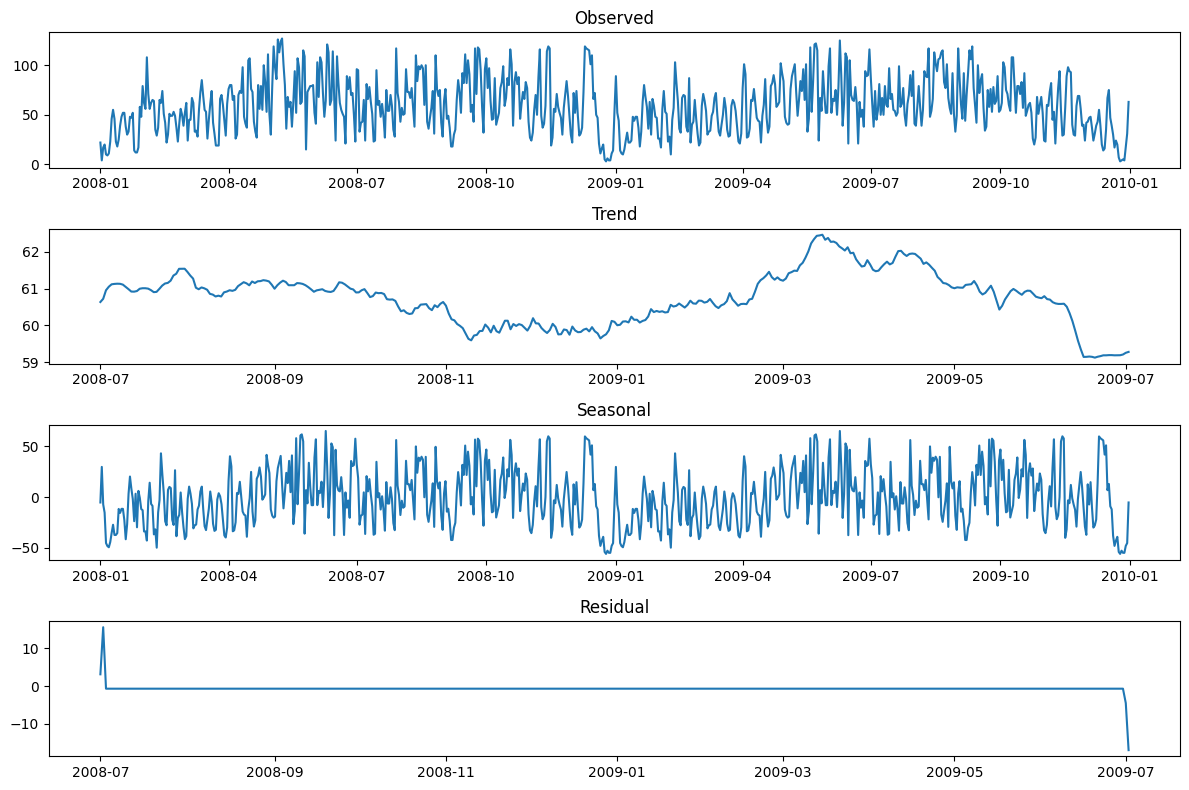

In [141]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(
    total_room_nights_by_date, model="additive", period=365
)

fig, ax = plt.subplots(4, 1, figsize=(12, 8))

ax[0].plot(decomposition.observed)
ax[0].set_title("Observed")

ax[1].plot(decomposition.trend)
ax[1].set_title("Trend")

ax[2].plot(decomposition.seasonal)
ax[2].set_title("Seasonal")

ax[3].plot(decomposition.resid)
ax[3].set_title("Residual")

plt.tight_layout()
plt.show()

The seasonal decomposition graph shows the breakdown of a time series into trend, seasonal, and residual components. Here's an analysis of each component based on the plots:

- Observed: This is the actual data we are analyzing. The plot shows fluctuations over time, and while there are patterns, it's not immediately clear what causes these fluctuations just from the observed data.

- Trend: The trend component shows a slight upward trajectory followed by a downward slope later. It indicates an initial increase in room nights booked, reaching a peak, and then a gradual decrease. There might be many reasons for this, including changes in the hotel's popularity, competition, or general market conditions. The sharp decline at the end suggests a significant event or change in conditions that may need further investigation.

- Seasonal: The seasonal plot displays consistent and regular patterns within each year, which indicates a **clear seasonality** in the data. These peaks and troughs repeat at similar intervals, suggesting that the hotel experiences regular periods of high and low demand, which could be tied to holiday seasons, local events, or other cyclical factors.

- Residual: Residuals are the left-over part of the data after the trend and seasonal components are removed. Ideally, residuals should show random noise if the model has captured all the patterns. The residual plot here shows some variability, which could be due to random fluctuations, or it might indicate additional patterns that the seasonal and trend components haven't captured. The spike at the end could be due to an outlier or a specific event not accounted for by the seasonal or trend components.

We determined our data is periodic in context of a year, but what about in context of a month? Do days in the week matter, is there a difference between weekdays and weekends?

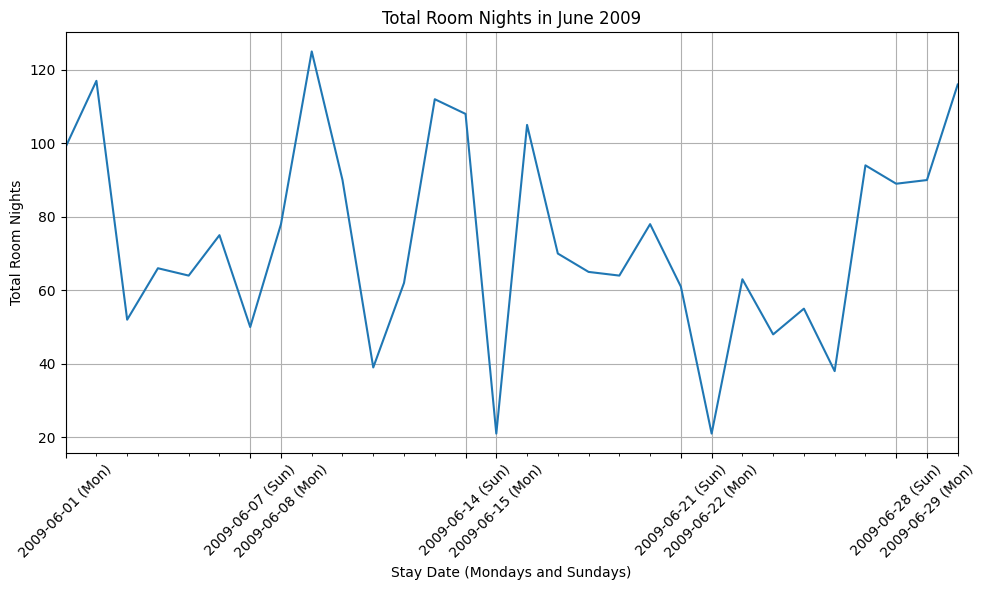

In [142]:
filtered_dataset = dataset[
    (dataset["stay_date"].dt.month == 6) & (dataset["stay_date"].dt.year == 2009)
]


total_room_nights_by_date = filtered_dataset.groupby("stay_date")["room_cnt"].sum()


plt.figure(figsize=(10, 6))

total_room_nights_by_date.plot(kind="line")


plt.gca().xaxis.set_major_locator(
    mdates.WeekdayLocator(byweekday=(mdates.MONDAY, mdates.SUNDAY))
)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d (%a)"))


plt.title("Total Room Nights in June 2009")

plt.xlabel("Stay Date (Mondays and Sundays)")

plt.ylabel("Total Room Nights")

plt.xticks(rotation=45)  # Rotate labels to prevent overlap

plt.grid(True)

plt.tight_layout()

plt.show()

We deliberetly picked the june month as it is the one with most bookings, and in the year of 2009 as it is the most recent year in our dataset. The results are expected, we see clearly that the bookings are periodic throughout the week. Peaks on mondays and drops on sundays.

### Conclusion of Timeframe Analysis
Based on our findings, we hypothethize that the data is periodic in a context of a year. Because of that further analysis of our data will be done for the year of 2009 only because it is the most recent year we have in our dataset

## Dataset Transformation
In this section we want to transform our dataset in a way that it will be suitable for model training.

### Date Representation
As dates are not a numerical column we need some sort of transformation. 
- From the previous section we notice that our data is periodic in the period of 1 year. Therefore we don't need to keep every the year explicitly but we can just have a column that represents a day in the year.
- Also we found out that weeks themself are periodic, where we have clear trends in days of the week. Because of that we will be keeping the week day as a column as well.


In [143]:
new_dataset = (
    dataset.groupby(["stay_date", "room_category_id"])["room_cnt"].sum().reset_index()
)
new_dataset["stay_date"] = pd.to_datetime(
    new_dataset["stay_date"]
)  # When using group by stay_date changes dtype

print(new_dataset.head(n=20))

    stay_date  room_category_id  room_cnt
0  2008-01-01                 2         1
1  2008-01-01                 4         3
2  2008-01-01                 5         4
3  2008-01-01                 6        11
4  2008-01-01                 7         3
5  2008-01-02                 5         4
6  2008-01-03                 2         2
7  2008-01-03                 3         6
8  2008-01-03                 4         1
9  2008-01-03                 5         7
10 2008-01-03                 6         1
11 2008-01-04                 2         3
12 2008-01-04                 3         5
13 2008-01-04                 4         1
14 2008-01-04                 5         4
15 2008-01-04                 6         6
16 2008-01-04                 7         1
17 2008-01-05                 2         2
18 2008-01-05                 3         3
19 2008-01-05                 5         4


In [144]:
new_dataset["day_of_week"] = new_dataset["stay_date"].dt.isocalendar().day
new_dataset["day_of_year"] = new_dataset["stay_date"].dt.dayofyear
print(new_dataset.head(n=20))

    stay_date  room_category_id  room_cnt  day_of_week  day_of_year
0  2008-01-01                 2         1            2            1
1  2008-01-01                 4         3            2            1
2  2008-01-01                 5         4            2            1
3  2008-01-01                 6        11            2            1
4  2008-01-01                 7         3            2            1
5  2008-01-02                 5         4            3            2
6  2008-01-03                 2         2            4            3
7  2008-01-03                 3         6            4            3
8  2008-01-03                 4         1            4            3
9  2008-01-03                 5         7            4            3
10 2008-01-03                 6         1            4            3
11 2008-01-04                 2         3            5            4
12 2008-01-04                 3         5            5            4
13 2008-01-04                 4         1       

## Weather
- '0' = rain
- '0.5' = snow
- '1' = sun

In [145]:
weather = pd.read_csv("weather/new_weather.csv")
weather.head()

,datetime,transformed_preciptype
0,2008-01-01,0.5
1,2008-01-02,0.5
2,2008-01-03,0.5
3,2008-01-04,1.0
4,2008-01-05,0.0


In [146]:
new_dataset["stay_date"] = pd.to_datetime(new_dataset["stay_date"])
weather["datetime"] = pd.to_datetime(weather["datetime"])

new_dataset = new_dataset.merge(
    weather[["datetime", "transformed_preciptype"]],
    left_on="stay_date",
    right_on="datetime",
    how="left",
)

new_dataset.drop(columns=["datetime"], inplace=True)
new_dataset.rename(columns={"transformed_preciptype": "weather"}, inplace=True)

In [147]:
new_dataset.head(n=20)

,stay_date,room_category_id,room_cnt,day_of_week,day_of_year,weather
0,2008-01-01,2,1,2,1,0.5
1,2008-01-01,4,3,2,1,0.5
2,2008-01-01,5,4,2,1,0.5
3,2008-01-01,6,11,2,1,0.5
4,2008-01-01,7,3,2,1,0.5
5,2008-01-02,5,4,3,2,0.5
6,2008-01-03,2,2,4,3,0.5
7,2008-01-03,3,6,4,3,0.5
8,2008-01-03,4,1,4,3,0.5
9,2008-01-03,5,7,4,3,0.5


Lets check how the weather impacts the number of bookings. But before that lets not take into account the room_category_id. We hypotethize that it will mess up with our correlation calculation.

In [148]:
weather_corr = (
    new_dataset.groupby("stay_date")
    .agg(
        {
            "room_cnt": "sum",
            "day_of_week": "first",
            "day_of_year": "first",
            "weather": "first",
        }
    )
    .reset_index()
)
weather_corr = weather_corr.drop("stay_date", axis=1)

weather_corr["room_cnt"] = round(
    weather_corr["room_cnt"] / weather_corr["room_cnt"].max(), 2
)

In [149]:
weather_corr.head()

,room_cnt,day_of_week,day_of_year,weather
0,0.17,2,1,0.5
1,0.03,3,2,0.5
2,0.13,4,3,0.5
3,0.16,5,4,1.0
4,0.08,6,5,0.0


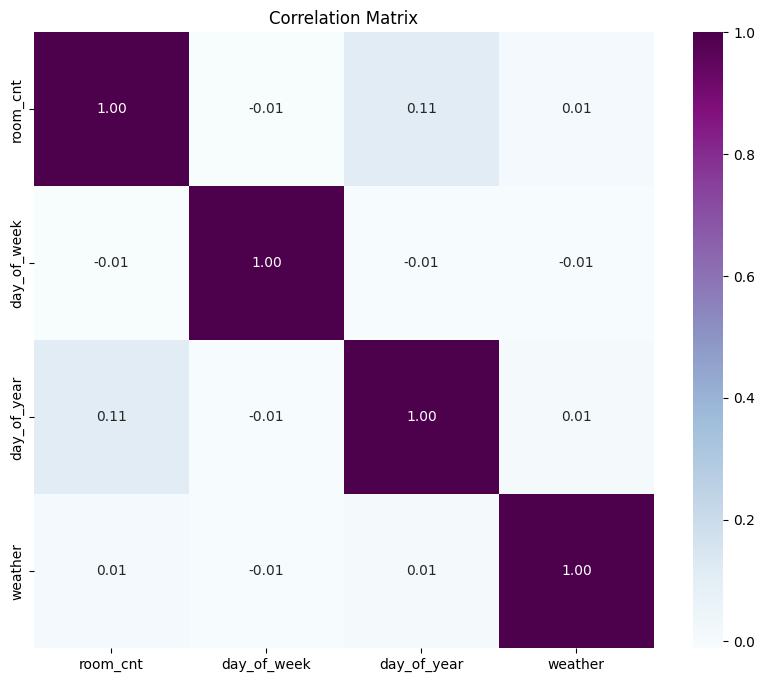

In [150]:
corr = weather_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="BuPu", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

There is not much, if any correlation for our weather. But lets check the more recent data in the dataset. As the older data doesn't have that much bookings.

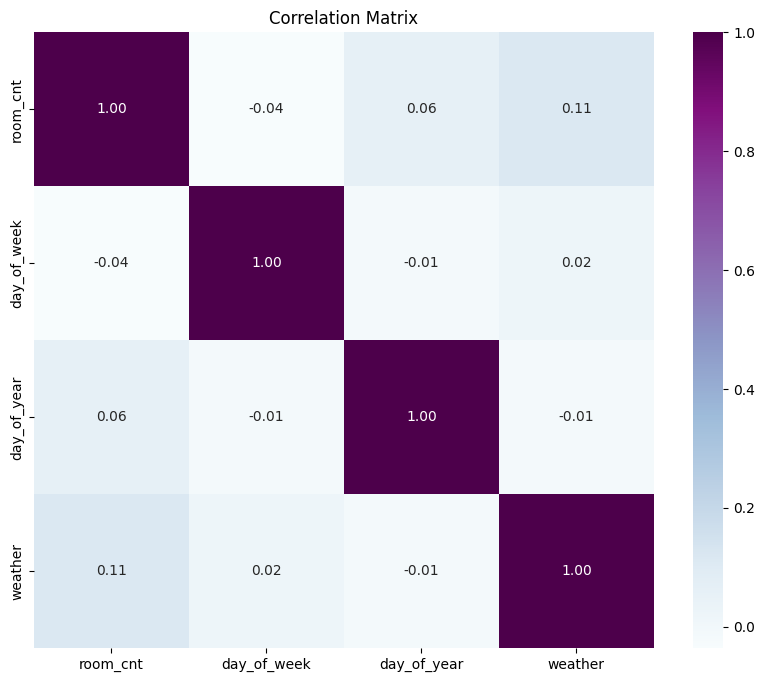

In [151]:
new_dataset_2009_corr = new_dataset[new_dataset["stay_date"].dt.year == 2009]

weather_corr_2009 = (
    new_dataset_2009_corr.groupby("stay_date")
    .agg(
        {
            "room_cnt": "sum",
            "day_of_week": "first",
            "day_of_year": "first",
            "weather": "first",
        }
    )
    .reset_index()
)

weather_corr_2009 = weather_corr_2009.drop("stay_date", axis=1)

weather_corr_2009["room_cnt"] = round(
    weather_corr_2009["room_cnt"] / weather_corr_2009["room_cnt"].max(), 2
)

corr = weather_corr_2009.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="BuPu", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

We see a significant increase in correlation when spectating the year of 2009 alone

### Room Category Id Representation

We need a way of giving different significance to different room_category_id. As some rooms are much more booked then the others. As we can see room with id 1 is booked 7 times in the year 2009 where the room with id 2 or 5 is booked over 8000 times. 

Also it is good to note that all of the room categories have at least one booking. As we analyzed in the dataset columns section, we see that all of the unique values (3  4  5  7  2  6 11  1) are indeed present bellow

In [152]:
dataset_2009 = dataset[dataset["stay_date"].dt.year == 2009]

reservations_per_room_type_2009 = (
    dataset_2009.groupby("room_category_id")["room_cnt"]
    .sum()
    .reset_index(name="room_cnt")
)

print(reservations_per_room_type_2009)

   room_category_id  room_cnt
0                 1         7
1                 2      8135
2                 3      2791
3                 4       316
4                 5      8284
5                 6      2000
6                 7        90
7                11        13


The idea we could use is that the category id of the room is in fact the number of times room with that category id was booked. This total number in the year of 2009, would then be mirrored onto the actual room_category_ids in the whole dataset. But to ensure this lets see if the room category id is corelated somehow to the date

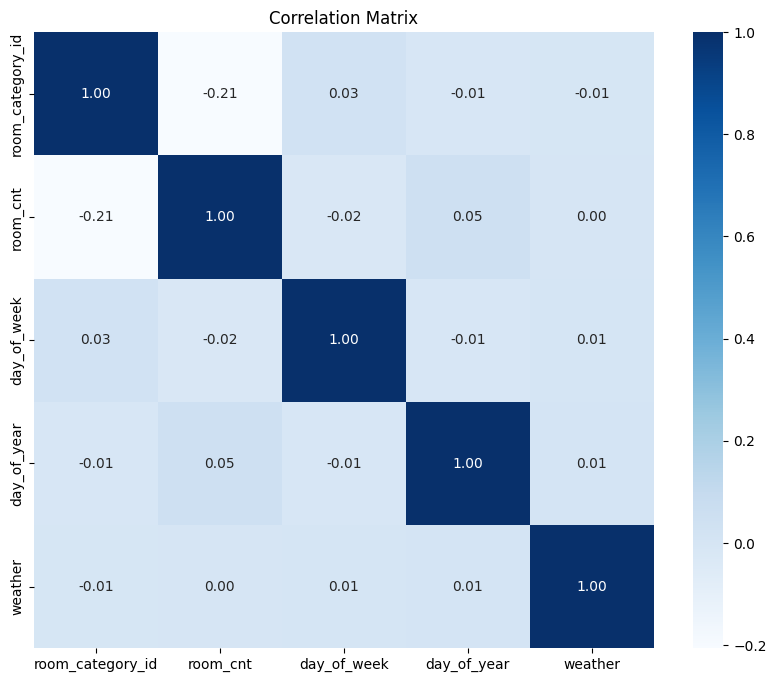

In [153]:
corr_dataset = new_dataset.drop("stay_date", axis=1)

corr = corr_dataset.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Our assumptions are confirmed, the room category has almost no corelation to the day_of_year and day_of_week. Therefore it is safe to use the total room_cnt per room type as our new id.

As we are planing on using the num of reservations per room as the room category id, we need to scale them based on the other values in our dataset. So between 0 and 1. It is also important to check if our new scaled_room_id is unique for all of the room_category_id, but as it turns out they are

In [154]:
max_reservations_2008 = reservations_per_room_type_2009["room_cnt"].max()

reservations_per_room_type_2009["scaled_room_id"] = round(
    reservations_per_room_type_2009["room_cnt"] / max_reservations_2008, 3
)

print(reservations_per_room_type_2009)

   room_category_id  room_cnt  scaled_room_id
0                 1         7           0.001
1                 2      8135           0.982
2                 3      2791           0.337
3                 4       316           0.038
4                 5      8284           1.000
5                 6      2000           0.241
6                 7        90           0.011
7                11        13           0.002


In [155]:
new_dataset = new_dataset.merge(
    reservations_per_room_type_2009[["room_category_id", "scaled_room_id"]],
    on="room_category_id",
    how="left",
)

In [156]:
print(new_dataset.head(n=20))

    stay_date  room_category_id  room_cnt  day_of_week  day_of_year  weather  \
0  2008-01-01                 2         1            2            1      0.5   
1  2008-01-01                 4         3            2            1      0.5   
2  2008-01-01                 5         4            2            1      0.5   
3  2008-01-01                 6        11            2            1      0.5   
4  2008-01-01                 7         3            2            1      0.5   
5  2008-01-02                 5         4            3            2      0.5   
6  2008-01-03                 2         2            4            3      0.5   
7  2008-01-03                 3         6            4            3      0.5   
8  2008-01-03                 4         1            4            3      0.5   
9  2008-01-03                 5         7            4            3      0.5   
10 2008-01-03                 6         1            4            3      0.5   
11 2008-01-04                 2         

## Events
In this sections we will join our events table with the current existing dataset

In [157]:
events = pd.read_json("./events/events.json")
events.head(10)

,name,type,date
0,Uskrs,[cultural holiday],"[{'start_date': '2008-03-23', 'finish_date': '..."
1,Božić,[cultural holiday],"[{'start_date': '2008-12-25', 'finish_date': '..."
2,Bogojavljenje,[cultural holiday],"[{'start_date': '2008-01-06', 'finish_date': '..."
3,Dani Svetog Vida,[cultural holiday],"[{'start_date': '2008-06-10', 'finish_date': '..."
4,Praznik rada,[cultural holiday],"[{'start_date': '2008-05-01', 'finish_date': '..."
5,Tijelovo,[cultural holiday],"[{'start_date': '2008-05-22', 'finish_date': '..."
6,Velika Gospa,[cultural holiday],"[{'start_date': '2008-08-15', 'finish_date': '..."
7,Dan drzavnosti Hrvatske,[cultural holiday],"[{'start_date': '2008-06-25', 'finish_date': '..."
8,Dan pobjede i domovinske zahvalnosti,[cultural holiday],"[{'start_date': '2008-08-05', 'finish_date': '..."
9,Dan neovisnosti,[cultural holiday],"[{'start_date': '2008-10-08', 'finish_date': '..."


As we can see, there are multiple types of events, and each of them are of their own importance in terms of popularity, days of lasting etc.

In [158]:
event_dates = events[["name", "date"]].explode("date")
exploded_dates = event_dates["date"].apply(pd.Series)
event_dates = pd.concat([event_dates, exploded_dates], axis=1).drop("date", axis=1)

event_dates["start_date"] = pd.to_datetime(event_dates["start_date"])
event_dates["finish_date"] = pd.to_datetime(event_dates["finish_date"])
event_dates

,name,start_date,finish_date
0,Uskrs,2008-03-23,2008-03-26
0,Uskrs,2009-04-12,2009-04-14
0,Uskrs,2010-04-04,2010-04-06
1,Božić,2008-12-25,2008-12-26
1,Božić,2009-12-25,2009-12-26
...,...,...,...
25,International Friendly Football Match,2009-10-08,2009-10-08
26,Rijeka Open Tennis Tournament,2008-05-05,2008-05-11
26,Rijeka Open Tennis Tournament,2009-06-29,2009-07-05
26,Rijeka Open Tennis Tournament,2010-09-06,2010-09-12


We're now going to integrate events into dataset.

In [159]:
new_dataset["isEvent"] = 0
new_dataset["eventName"] = ""


for _, row in event_dates.iterrows():
    locs = (new_dataset["stay_date"] >= row["start_date"]) & (
        new_dataset["stay_date"] <= row["finish_date"]
    )

    new_dataset.loc[locs, "isEvent"] += 1
    new_dataset.loc[locs, "eventName"] += f"{row["name"]}\\"


print(new_dataset.head(n=20))

    stay_date  room_category_id  room_cnt  day_of_week  day_of_year  weather  \
0  2008-01-01                 2         1            2            1      0.5   
1  2008-01-01                 4         3            2            1      0.5   
2  2008-01-01                 5         4            2            1      0.5   
3  2008-01-01                 6        11            2            1      0.5   
4  2008-01-01                 7         3            2            1      0.5   
5  2008-01-02                 5         4            3            2      0.5   
6  2008-01-03                 2         2            4            3      0.5   
7  2008-01-03                 3         6            4            3      0.5   
8  2008-01-03                 4         1            4            3      0.5   
9  2008-01-03                 5         7            4            3      0.5   
10 2008-01-03                 6         1            4            3      0.5   
11 2008-01-04                 2         

Lets see how are events corelated to the number of bookings

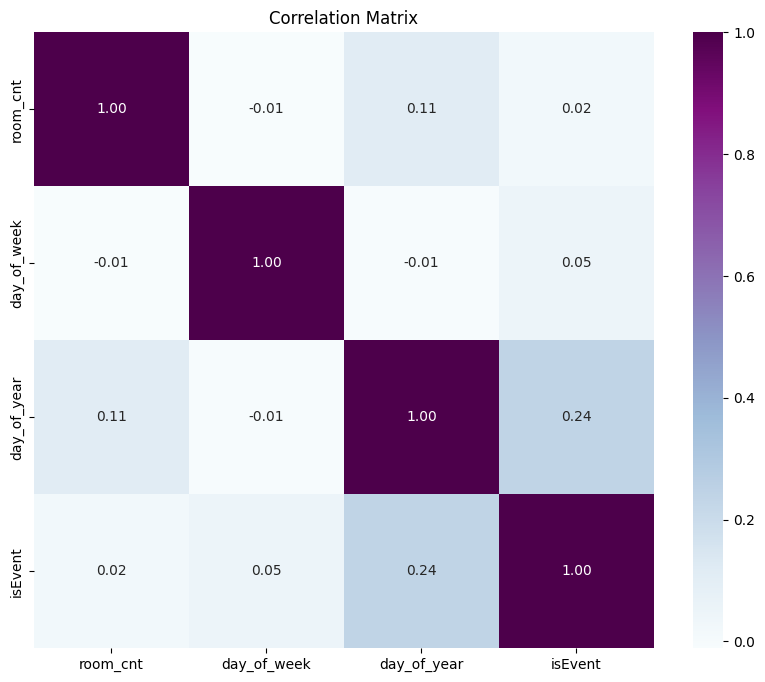

In [160]:
events_corr = (
    new_dataset.groupby("stay_date")
    .agg(
        {
            "room_cnt": "sum",
            "day_of_week": "first",
            "day_of_year": "first",
            "isEvent": "first",
        }
    )
    .reset_index()
)

events_corr = events_corr.drop("stay_date", axis=1)

events_corr["room_cnt"] = round(
    events_corr["room_cnt"] / events_corr["room_cnt"].max(), 2
)

corr = events_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="BuPu", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Saving Dataset First Version


In [161]:
new_dataset = new_dataset.drop("room_category_id", axis=1)

In [162]:
new_dataset = new_dataset.drop("stay_date", axis=1)

In [163]:
print(new_dataset.head(n=20))

    room_cnt  day_of_week  day_of_year  weather  scaled_room_id  isEvent  \
0          1            2            1      0.5           0.982        0   
1          3            2            1      0.5           0.038        0   
2          4            2            1      0.5           1.000        0   
3         11            2            1      0.5           0.241        0   
4          3            2            1      0.5           0.011        0   
5          4            3            2      0.5           1.000        0   
6          2            4            3      0.5           0.982        0   
7          6            4            3      0.5           0.337        0   
8          1            4            3      0.5           0.038        0   
9          7            4            3      0.5           1.000        0   
10         1            4            3      0.5           0.241        0   
11         3            5            4      1.0           0.982        0   
12         5

In [164]:
new_dataset.to_parquet("../lumen_dataset/boris_step_1.parquet", index=False)
new_dataset.to_csv("../lumen_dataset/boris_step_1.csv", index=False)